In [1]:
#ls /data

In [2]:
#cp -v /data/ml2021spring-hw3.zip ~/

In [3]:
#!unzip ml2021spring-hw3.zip

In [4]:
#pip install torchsummary

导入所需库

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import ImageFolder
print('done')

done


定义训练数据和测试数据的transform方式

In [6]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((128, 128)),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.6),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.7, 1.3)),
    transforms.ToTensor(),
])
#训练数据只需要裁剪到输入规定的大小即可
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [7]:
train_set = ImageFolder("food-11/training/labeled",transform=train_transform)
valid_set = ImageFolder("food-11/validation", transform=test_transform)
unlabeled_set = ImageFolder("food-11/training/unlabeled",transform=train_transform)
test_set = ImageFolder("food-11/testing",transform=test_transform)
print(train_set.class_to_idx)
batch_size=128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)#workers多线程读取，pin_memory加速读取
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

{'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5, '06': 6, '07': 7, '08': 8, '09': 9, '10': 10}


网络结构定义

In [8]:
class CNNclassifier(nn.Module):
    def __init__(self):
        super(CNNclassifier, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3,32,4,1),#输入channel，输出channel，4x4卷积核，步长1，padding=0
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,1,0),#3x3，步长1

            nn.Conv2d(32, 64, 4, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,1,0),

            nn.Conv2d(64, 128, 4, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,1,0),

            nn.Conv2d(128, 256, 3, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4,2,0),

            nn.Conv2d(256, 512, 3, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(4,2,0),

            nn.Conv2d(512, 1024, 3, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(4,2,0),

            nn.Conv2d(1024, 1024, 3, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(4,2,0)
        )

        self.fullconnect_layers = nn.Sequential(
            nn.Linear(9216, 1024),#1024x3x3
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]
        x = self.cnn_layers(x)
        x = x.flatten(1)
        x = self.fullconnect_layers(x)
        return x

半监督标注所需函数

In [9]:
class PseudoDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id][0], self.y[id]

def get_pseudo_labels(dataset, model, threshold=0.9):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    softmax = nn.Softmax(dim=-1)

    idx = []
    labels = []

    for i, batch in enumerate(data_loader):
        img, _ = batch
        with torch.no_grad():
            logits = model(img.to(device))
        probs = softmax(logits)

        for j, x in enumerate(probs):
            if torch.max(x) > threshold:
                idx.append(i * batch_size + j)
                labels.append(int(torch.argmax(x)))

    model.train()
    print ("\nNew data: {:5d}\n".format(len(idx)))
    dataset = PseudoDataset(Subset(dataset, idx), labels)
    return dataset

#############训练###############

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CNNclassifier().to(device)
model.device = device

#from torchsummary import summary
#summary(model, input_size=(3, 128, 128), device=device)#可视化神经网络结构


criterion = nn.CrossEntropyLoss()#交叉熵损失内置了softmax故前面网络结构末尾没有使用softmax
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

n_epochs = 500
do_semi = True
model_path = "model.ckpt"

best_acc = 0.0
train_loss_record = []
valid_loss_record = []
train_acc_record = []
valid_acc_record = []

for epoch in range(n_epochs):
    if do_semi and best_acc > 0.75 and epoch % 5 == 0:#准确率达到0.7以上才开始每5论半监督一次
        pseudo_set = get_pseudo_labels(unlabeled_set, model)
        concat_dataset = ConcatDataset([train_set, pseudo_set])#添加半监督标注数据参与训练
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)

    model.train()

    train_loss = []
    train_accs = []

    for batch in train_loader:
        imgs, labels = batch
        logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)#梯度裁剪，处理梯度爆炸，max越大越温和

        optimizer.step()

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    print(f"[ Train | {epoch + 1:03d} / {n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    model.eval()

    valid_loss = []
    valid_accs = []

    for batch in valid_loader:
        imgs, labels = batch

        with torch.no_grad():
            logits = model(imgs.to(device))

        loss = criterion(logits, labels.to(device))

        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc)

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    print(f"[ Valid | {epoch + 1:03d} / {n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
    train_loss_record.append(train_loss)
    valid_loss_record.append(valid_loss)
    train_acc_record.append(train_acc)
    valid_acc_record.append(valid_acc)

[ Train | 001 / 500 ] loss = 2.44022, acc = 0.12312
[ Valid | 001 / 500 ] loss = 2.67870, acc = 0.08516
[ Train | 002 / 500 ] loss = 2.36813, acc = 0.15344
[ Valid | 002 / 500 ] loss = 2.23625, acc = 0.20078
[ Train | 003 / 500 ] loss = 2.32057, acc = 0.18906
[ Valid | 003 / 500 ] loss = 2.19535, acc = 0.25417
[ Train | 004 / 500 ] loss = 2.27354, acc = 0.19406
[ Valid | 004 / 500 ] loss = 2.07437, acc = 0.28958
[ Train | 005 / 500 ] loss = 2.23357, acc = 0.22344
[ Valid | 005 / 500 ] loss = 2.00952, acc = 0.29870
[ Train | 006 / 500 ] loss = 2.21657, acc = 0.21813
[ Valid | 006 / 500 ] loss = 2.04606, acc = 0.33073
[ Train | 007 / 500 ] loss = 2.17144, acc = 0.23500
[ Valid | 007 / 500 ] loss = 1.89631, acc = 0.33880
[ Train | 008 / 500 ] loss = 2.19175, acc = 0.23187
[ Valid | 008 / 500 ] loss = 1.90293, acc = 0.35938
[ Train | 009 / 500 ] loss = 2.18749, acc = 0.21688
[ Valid | 009 / 500 ] loss = 1.93122, acc = 0.29609
[ Train | 010 / 500 ] loss = 2.19150, acc = 0.23375
[ Valid | 01

在test上分类并保存结果

In [11]:
model.eval()

predictions = []

for batch in test_loader:
    imgs, labels = batch

    with torch.no_grad():
        logits = model(imgs.to(device))

    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

with open("predict.csv", "w") as f:
    f.write("Id,Category\n")

    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")

[7]


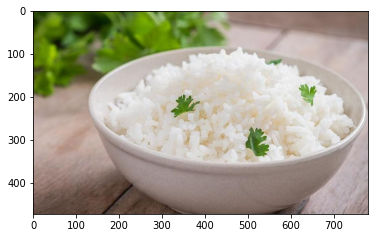

In [47]:
model.eval()
from PIL import Image
import matplotlib.pyplot as plt
img =Image.open('./test/00/0000.jpg')
plt.imshow(img)
img_tensor = test_transform(img) 
img_tensor=img_tensor.unsqueeze(0)


with torch.no_grad():
    logits = model(img_tensor.to(device))
print(logits.argmax(dim=-1).cpu().numpy().tolist())


